# Exponential Machines

[Exponential machines (Novikov et al., 2017)](https://arxiv.org/pdf/1605.03795.pdf) are predictors that are able to model all $2^N$ interactions between $N$ features. Those interactions are limited to being of degree 1, i.e. the regressor is of the form 

$$f(x_1, \dots, x_N) = \sum_{\alpha \subseteq \{1, \dots, N\}} \left( w_{\alpha} \cdot \prod_{n \in \alpha} x_n \right)$$

and fitting the regressor means finding the best $w_{\alpha}$ for all $2^N$ possible $\alpha$'s. Besides the $L^2$ loss on the training data, the original paper also adds an $L^2$ regularization term ("ridge") on the set of weights $w$.

We note that an exponential machine is equivalent to a TT-Tucker model with Tucker rank equal to 2: the first column of the Tucker factors should be a constant ($1$), and the second column should be linear ($x$). To this end, we can use for example a Legendre expansion of polynomials truncated to 2 basis elements. Note that this can be seen as a particular case of a [polynomial chaos expansion](pce.ipynb).

We will try here a synthetic model with noise: $f^{\mathrm{true}}(x_1, \dots, x_5) = x_1 x_2 x_3 + x_1 x_2 x_3 x_4 x_5 + \varepsilon$:

In [1]:
import torch
import tntorch as tn

P = 100
ntrain = int(P*0.75)
N = 5
ticks = 32  # We will use a 32^5 tensor

X = torch.rand(P, N)*2 - 1  # Features between -1 and 1
y = torch.prod(X, dim=1) + torch.prod(X[:, :3], dim=1)
y += torch.randn(y.shape)*torch.std(y)/10  # Gaussian noise: 1/5th of the clean signal's sigma
X = (X+1)/2*(ticks-1)  # Make feature between 0 and ticks-1, i.e. indexable by the tensor

# Split into train/test
X_train = X[:ntrain]
y_train = y[:ntrain]
X_test = X[ntrain:]
y_test = y[ntrain:]

A TT-rank of 2 should be enough to fit this data set, since it arises from the sum of exactly two interactions.

In [2]:
t = tn.rand(shape=[ticks]*N, ranks_tt=2, ranks_tucker=2, requires_grad=True)
t.set_factors('legendre', requires_grad=False)  # We set the factors to Legendre polynomials, and fix them (won't be changed during optimization) 

In [3]:
def loss(t):
    return tn.relative_error(y_train, t[X_train])**2
tn.optimize(t, loss)

iter: 0      | loss:   7.956270 | total time:    0.0022
iter: 500    | loss:   0.475733 | total time:    0.9688
iter: 1000   | loss:   0.071103 | total time:    1.8799
iter: 1500   | loss:   0.024970 | total time:    2.8605
iter: 2000   | loss:   0.013503 | total time:    3.9351
iter: 2500   | loss:   0.009449 | total time:    5.0269
iter: 3000   | loss:   0.007776 | total time:    6.1072
iter: 3500   | loss:   0.007118 | total time:    7.1863
iter: 3532   | loss:   0.007094 | total time:    7.2544 <- converged (tol=0.0001)


In [4]:
print('Test relative error:', tn.relative_error(y_test, t[X_test]))

Test relative error: tensor(0.1051, grad_fn=<DivBackward1>)


The tensor of weights ($\mathcal{W}$ in the original paper) can be retrieved as the TT part of our TT-Tucker tensor:

In [5]:
core = tn.Tensor(t.cores)
core

5D TT tensor:

  2   2   2   2   2
  |   |   |   |   |
 (0) (1) (2) (3) (4)
 / \ / \ / \ / \ / \
1   2   2   2   2   1

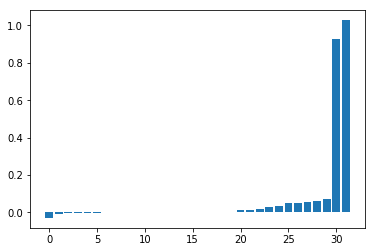

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.figure()
plt.bar(np.arange(core.size), np.sort(core.numpy().flatten()))
plt.show()

Despite the noise, the model correctly retrieved the two interacting components. Those indeed correspond to $x_1 x_2 x_3$ and $x_1 x_2 x_3 x_4 x_5$:

In [7]:
print(core[1, 1, 1, 0, 0])
print(core[1, 1, 1, 1, 1])

tensor(1.0280, grad_fn=<SqueezeBackward0>)
tensor(0.9253, grad_fn=<SqueezeBackward0>)


The orders of participating interactions (namely, 3 and 5) can be revealed as well by the [dimension distribution](sobol.ipynb):

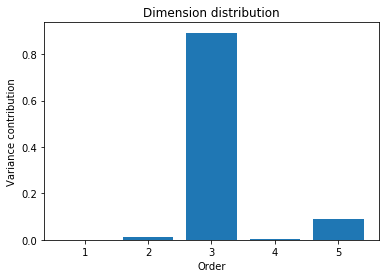

In [8]:
plt.figure()
plt.bar(np.arange(1, N+1), tn.dimension_distribution(t).numpy())
plt.xlabel('Order')
plt.ylabel('Variance contribution')
plt.title('Dimension distribution')
plt.show()